## DATA PREPROCESSING

his section outlines the preprocessing steps performed to prepare the data for model training:

1. **Remove Irrelevant Features and Handle Missing Values:** The data was cleaned by removing irrelevant features and addressing missing values.

2. **Feature Engineering:** New features were engineered to capture additional information that could enhance the model's performance.

3. **Encoding Categorical Variables:** Categorical variables were encoded into numerical format for compatibility with the modeling process.

4. **Balancing Dataset:** To address data imbalance, random undersampling was applied to create a more balanced dataset for training purposes.

In [1]:
import pandas as pd
raw_data = pd.read_csv("./data/2016-09-19_79351_training.csv")

### Removing useless features

In [2]:
raw_data = raw_data.drop(columns=['dataset_transaction', 'dataset_user'])

### Handling missing values

In [3]:
# checking for in all features
print(raw_data.isnull().sum())

user_id                  0
transaction_date         0
transaction_type         0
mcc_group           150222
amount_currency          0
dtype: int64


In [4]:
# check for missing values in mcc_group
mcc_group_len = len(raw_data['mcc_group'])
missing_values = raw_data['mcc_group'].isnull().sum()
print(f"All values: {mcc_group_len}")
print(f"Missing values: {missing_values}")


All values: 408546
Missing values: 150222


In [5]:
# Replace "NaN" strings with actual NaN values
raw_data['mcc_group']= raw_data['mcc_group'].replace("NaN", float("NaN"))

# Replace NaN values with 0
raw_data['mcc_group'] = raw_data['mcc_group'].fillna(0).astype(int)

In [6]:
# Check if missing values have been replaced
print("Missing values after filling with 0:")
print(raw_data.isnull().sum())

Missing values after filling with 0:
user_id             0
transaction_date    0
transaction_type    0
mcc_group           0
amount_currency     0
dtype: int64


### Feature Engineering

In [7]:
# Transforminf transaction_date to date format
raw_data['transaction_date'] = pd.to_datetime(raw_data['transaction_date'])

# Extract day and adding it as a new feature
raw_data['transaction_day'] = raw_data['transaction_date'].dt.day

# Removing 'transaction_date' feature
raw_data = raw_data.drop(columns=['transaction_date'])


### Enconding Variables in One Hot Encoding / Label encoding 

#### 1. Applying Label encoding to 'user_id' feature

In [8]:
raw_data.tail()

,user_id,transaction_type,mcc_group,amount_currency,transaction_day
408541,bc639c7495889105713fc6b1025264ac,DT,0,5,31
408542,0dfb685e3d705957ef9e0c472604b067,DT,0,155,31
408543,918eb93c2d3b084614e3570886715f84,DT,0,19,31
408544,918eb93c2d3b084614e3570886715f84,DT,0,19,31
408545,25afbb78936ce100bbd1e61cecb37403,DT,0,36,31


In [9]:
from sklearn.preprocessing import LabelEncoder
import pickle
# Encoding the user id
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder to user_id column
label_encoder.fit(raw_data['user_id'])
raw_data['user_id'] = label_encoder.transform(raw_data['user_id'])

# Save LabelEncoder to a file using pickle
with open('./encoder/label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

In [10]:
raw_data.head()

,user_id,transaction_type,mcc_group,amount_currency,transaction_day
0,6549,DT,0,350,1
1,6903,DT,0,202,1
2,4863,DT,0,291,1
3,8005,DT,0,214,1
4,2922,DT,0,272,1


#### 2. Applying one hot encoding to 'transaction_type' and 'mcc_group'

Applying one-hot encoding to 'transaction_type' and 'mcc_group' is beneficial due to their low cardinality, meaning they have only a few distinct values. This encoding technique efficiently represents these categorical features in a binary format, which is simple and computationally efficient, making it suitable for our modeling task

In [11]:
# Perform one-hot encoding
one_hot_encoded_type = pd.get_dummies(raw_data['transaction_type'], prefix='transaction')
one_hot_encoded_mcc_group = pd.get_dummies(raw_data['mcc_group'], prefix='mcc_group')
# Convert True/False to 1/0
one_hot_encoded_type = one_hot_encoded_type.astype(int)
one_hot_encoded_mcc_group = one_hot_encoded_mcc_group.astype(int)

# Concatenate one-hot encoded features with original DataFrame
raw_data = pd.concat([raw_data, one_hot_encoded_type, one_hot_encoded_mcc_group], axis=1)

# Removing 'transaction_date' feature
raw_data = raw_data.drop(columns=['transaction_type', 'mcc_group'])

In [12]:
raw_data.head()

,user_id,amount_currency,transaction_day,transaction_BBU,transaction_BUB,transaction_CT,transaction_DD,transaction_DR,transaction_DT,transaction_FT,...,mcc_group_8,mcc_group_9,mcc_group_10,mcc_group_11,mcc_group_12,mcc_group_13,mcc_group_14,mcc_group_15,mcc_group_16,mcc_group_17
0,6549,350,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,6903,202,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,4863,291,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,8005,214,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,2922,272,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


### Splitting the dataset
- Splitting the dataset in: train, validation (hyperparameter tuning) and test sets

In [14]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import numpy as np


def random_undersampling_regression(X, y, ratio=0.6, random_state=42):
    """
    Perform random undersampling to balance the classes for regression problems.
    
    Parameters:
    X (array-like): Features.
    y (array-like): Target variable.
    ratio (float): Ratio of majority class samples to keep. Default is 1.0 (keeping all samples).
    random_state (int): Random seed for reproducibility.
    
    Returns:
    X_resampled (array-like): Undersampled features.
    y_resampled (array-like): Undersampled target variable.
    """
    # Combine features and target into one array
    data = np.column_stack((X, y))
    
    # Shuffle the data
    np.random.seed(random_state)
    np.random.shuffle(data)
    
    # Calculate the number of samples to keep
    n_samples_keep = int(len(data) * ratio)
    
    # Select a subset of samples
    undersampled_data = data[:n_samples_keep]
    
    # Separate features and target variable
    X_resampled = undersampled_data[:, :-1]
    y_resampled = undersampled_data[:, -1]
    
    return X_resampled, y_resampled

y = raw_data['amount_currency']
x = raw_data.drop(columns=['amount_currency'])
x_train_temp, x_test, y_train_temp, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
# Applying undersampling to reduce imbalance
x_train_resampled, y_train_resampled = random_undersampling_regression(x_train_temp, y_train_temp)
# Further split the temporary set into validation and test sets
x_train, x_val, y_train, y_val = train_test_split(x_train_resampled, y_train_resampled, test_size=0.25, random_state=42)



## MODEL TRAINING

### Initial model training

In [15]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Random Forest Regressor model using the default hyperparameters values
rf_regressor = RandomForestRegressor(random_state=42)

cv_scores = cross_val_score(rf_regressor, x_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Convert negative MSE scores to positive values
mse_scores = -cv_scores

# Calculate mean and standard deviation of MSE scores
mean_mse = mse_scores.mean()
std_mse = mse_scores.std()

print("Mean Squared Error (MSE) scores:", mse_scores)
print("Mean MSE:", mean_mse)
print("Standard Deviation of MSE:", std_mse)


Mean Squared Error (MSE) scores: [11354.22262324 10722.05546561 10737.50683569 10318.0423951
 10985.84427342]
Mean MSE: 10823.53431861223
Standard Deviation of MSE: 340.9385188737055


### Hyperparameter 

- Optimization of the same regression model used in training.
- Utilizing BayesSearch algorithm for efficiency.
- Aim: Identify hyperparameter configuration maximizing model performance.
- Goal: Enhance predictive accuracy and generalization ability.

In [16]:
from skopt import BayesSearchCV
from skopt.space import Integer
from sklearn.ensemble import RandomForestRegressor

# Define the simplified search space
param_space = {
    'n_estimators': Integer(50, 100),      # Reduce range of number of trees
    'max_depth': Integer(1, 10),            # Reduce range of maximum depth
    'min_samples_split': Integer(2, 5),     # Reduce range of minimum samples required to split a node
    'min_samples_leaf': Integer(1, 3)       # Reduce range of minimum samples required at each leaf node
}

# Create a Random Forest Regressor model
rf_regressor = RandomForestRegressor(random_state=42)

# Perform Bayesian optimization with cross-validation
bayes_search = BayesSearchCV(
    estimator=rf_regressor, 
    search_spaces=param_space, 
    n_iter=5,           # Reduced number of iterations
    cv=5,                # Number of folds for cross-validation
    scoring='neg_mean_squared_error', 
    random_state=42,
    verbose=3            # Set verbosity to see progress
)
bayes_search.fit(x_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", bayes_search.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=66;, score=-10367.497 total time=  15.2s
[CV 2/5] END max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=66;, score=-9974.947 total time=  15.1s
[CV 3/5] END max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=66;, score=-9849.475 total time=  13.6s
[CV 4/5] END max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=66;, score=-9640.503 total time=  13.6s
[CV 5/5] END max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=66;, score=-10078.451 total time=  13.8s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END max_depth=9, min_samples_leaf=3, min_samples_split=3, n_estimators=98;, score=-10204.719 total time=  30.9s
[CV 2/5] END max_depth=9, min_samples_leaf=3, min_samples_split=3, n_estimators=98;, score=-9810.950 total time=  31.4s
[CV 3/5] END max_depth=9, min_samples_l

In [17]:
# Evaluate the best model on the validation set
best_model = bayes_search.best_estimator_
predicted_val = best_model.predict(x_val)
mse_val = mean_squared_error(y_val, predicted_val)
print("Mean Squared Error on Validation Set:", mse_val)

Mean Squared Error on Validation Set: 10143.82531711268


## EVALUATION

- Mean Squared Error (MSE): Measures the average squared difference between predicted and actual values, providing a measure of prediction accuracy.
- Root Mean Squared Error (RMSE): Represents the square root of MSE, indicating the average error in the predicted values.
- Mean Absolute Error (MAE): Calculates the average absolute difference between predicted and actual values, offering another measure of prediction accuracy.
- Explained Variance Score: Indicates the proportion of variance in the target variable explained by the model, with higher values indicating better predictive performance.
- Median Absolute Error (MedAE): Computes the median absolute difference between predicted and actual values, providing a robust measure of central tendency.
- R-squared (R2) Score: Measures the proportion of variance in the target variable explained by the model, with values closer to 1 indicating better model fit.

In [18]:
# Finally, train the final model on the entire train and validation sets using the best hyperparameters obtained
final_model = best_model.fit(x_train_temp, y_train_temp)

# Save the final model to a file using pickle
with open('./model/final_model.pkl', 'wb') as file:
    pickle.dump(final_model, file)

# Evaluate the final model on the test set
predicted_test = final_model.predict(x_test)
mse_test = mean_squared_error(y_test, predicted_test)
print("Mean Squared Error on Test Set:", mse_test)

Mean Squared Error on Test Set: 10224.199144233266


In [19]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score, median_absolute_error

# Evaluate the best model
predicted_test = final_model.predict(x_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, predicted_test)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predicted_test)
explained_variance = explained_variance_score(y_test, predicted_test)
medae = median_absolute_error(y_test, predicted_test)
r2 = r2_score(y_test, predicted_test)

# Print evaluation metrics
print("Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Explained Variance Score: {explained_variance:.2f}")
print(f"Median Absolute Error (MedAE): {medae:.2f}")
print(f"R-squared (R2) Score: {r2:.2f}")


Evaluation Metrics:
Mean Squared Error (MSE): 10224.20
Root Mean Squared Error (RMSE): 101.11
Mean Absolute Error (MAE): 48.19
Explained Variance Score: 0.20
Median Absolute Error (MedAE): 19.95
R-squared (R2) Score: 0.20


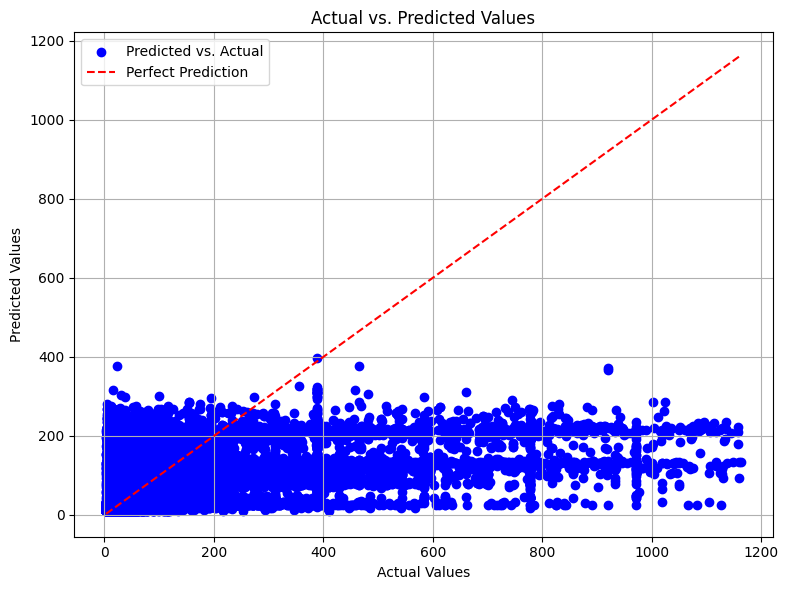

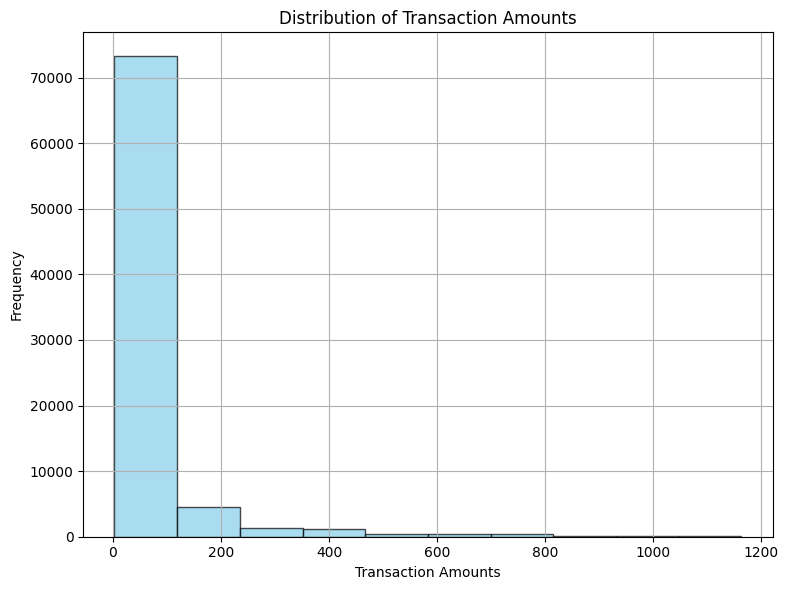

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
actual_values = y_test
predicted_values = predicted_test

# Scatter plot of predicted vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(actual_values, predicted_values, color='blue', label='Predicted vs. Actual')
plt.plot([min(actual_values), max(actual_values)], 
         [min(actual_values), max(actual_values)], 
         color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Histogram of transaction amounts
plt.figure(figsize=(8, 6))
plt.hist(actual_values, bins=10, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Transaction Amounts')
plt.ylabel('Frequency')
plt.title('Distribution of Transaction Amounts')
plt.grid(True)
plt.tight_layout()
plt.show()
